# TSP Metaheuristic Portfolio
Tabu Search vs Genetic Algorithm
Author: Hiruni Keshika
UWE ID: 25034972


In [4]:
"""

This notebook implements two optimisation algorithms for the TSP:
1. Tabu Search (single-solution local metaheuristic)
2. Genetic Algorithm (population-based evolutionary search)

"""

import numpy as np
import pandas as pd
import random
import time
import logging
import matplotlib.pyplot as plt
from math import hypot
from typing import List, Tuple

logging.basicConfig(
    filename="../results/run_log.txt",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)


In [6]:
def load_cities(path: str) -> pd.DataFrame:
    """
    Load city coordinates from CSV file.

    Args:
        path (str): Relative filepath to cities.csv

    Returns:
        pd.DataFrame: DataFrame with X,Y coordinates columns.

    Raises:
        FileNotFoundError: if CSV cannot be located.
        ValueError: if dataset missing required columns.
    """
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        raise FileNotFoundError("cities.csv not found. Check /data folder and filename.")

    if not {"X", "Y"}.issubset(df.columns):
        raise ValueError("Dataset must contain X and Y columns")

    logging.info(f"Dataset loaded successfully with {len(df)} cities.")
    return df


df = load_cities("../data/cities.csv")
coords = df[['X', 'Y']].values
n_cities = len(coords)
df.head()       
df.shape


(50, 3)

In [8]:
def compute_distance_matrix(coords: np.ndarray) -> np.ndarray:
    """
    Compute Euclidean distance matrix for TSP.

    Args:
        coords (np.ndarray): Array of city coordinates (n x 2)

    Returns:
        np.ndarray: Pairwise distance matrix (n x n)
    """
    n = len(coords)
    dist = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            d = hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])
            dist[i, j] = d
            dist[j, i] = d

    logging.info("Distance matrix computed successfully.")
    return dist


dist_matrix = compute_distance_matrix(coords)


In [10]:
random.seed(42)
np.random.seed(42)

def route_cost(route: List[int], dist: np.ndarray) -> float:
    """
    Evaluate total travel distance of a route.

    Args:
        route (List[int]): Visiting order of cities.
        dist (np.ndarray): Full distance matrix.

    Returns:
        float: total route length.
    """
    return sum(dist[route[i - 1]][route[i]] for i in range(len(route)))


In [12]:
def two_opt(route: List[int]) -> List[int]:
    """
    Perform 2-opt local swap for neighbourhood exploration.

    Args:
        route (List[int]): Current candidate.

    Returns:
        List[int]: New improved neighbouring route.
    """
    a, b = sorted(random.sample(range(len(route)), 2))
    return route[:a] + route[a:b+1][::-1] + route[b+1:]


In [14]:
def tabu_search(dist: np.ndarray, tabu_tenure: int = 15, iterations: int = 500
               ) -> Tuple[List[int], float, List[float]]:
    """
    Perform Tabu Search for TSP with aspiration criteria.

    Args:
        dist (np.ndarray): distance matrix
        tabu_tenure (int): tabu list memory limit
        iterations (int): stopping condition

    Returns:
        best (List[int]): best route found
        best_cost (float): total route length
        history (List[float]): convergence improvement record
    """
    n = len(dist)
    curr = list(range(n))
    random.shuffle(curr)

    best = curr[:]
    best_cost = route_cost(best, dist)

    tabu_list = []
    history = [best_cost]

    for _ in range(iterations):
        candidate = two_opt(curr[:])
        candidate_cost = route_cost(candidate, dist)

        # Aspiration: accept even if tabu if better than best
        if candidate not in tabu_list or candidate_cost < best_cost:
            curr = candidate
            if candidate_cost < best_cost:
                best, best_cost = candidate[:], candidate_cost

        tabu_list.append(candidate)
        tabu_list = tabu_list[-tabu_tenure:]

        history.append(best_cost)

    logging.info(f"Tabu best cost: {best_cost}")
    return best, best_cost, history


In [16]:
def ga(dist: np.ndarray, pop_size: int = 80, generations: int = 300,
       mutation_rate: float = 0.15) -> Tuple[List[int], float, List[float]]:
    """
    Perform GA with PMX crossover & swap mutation.

    Args:
        dist (np.ndarray): distance matrix
        pop_size (int): number of routes in population
        generations (int): stopping condition
        mutation_rate (float): probability of mutation

    Returns:
        best (List[int]): best route evolved
        best_cost (float): route length
        history (List[float]): convergence improvements
    """
    n = len(dist)
    population = [random.sample(range(n), n) for _ in range(pop_size)]
    best = min(population, key=lambda r: route_cost(r, dist))
    best_cost = route_cost(best, dist)
    history = [best_cost]

    for _ in range(generations):
        parents = random.sample(population, 2)
        child = pmx(parents[0], parents[1])

        if random.random() < mutation_rate:
            mutate(child)

        population.append(child)
        population = sorted(population, key=lambda r: route_cost(r, dist))[:pop_size]

        if route_cost(population[0], dist) < best_cost:
            best = population[0][:]
            best_cost = route_cost(best, dist)

        history.append(best_cost)

    logging.info(f"GA best cost: {best_cost}")
    return best, best_cost, history


## Tabu convergence plot

Final Tabu best cost: 2316.541578992475


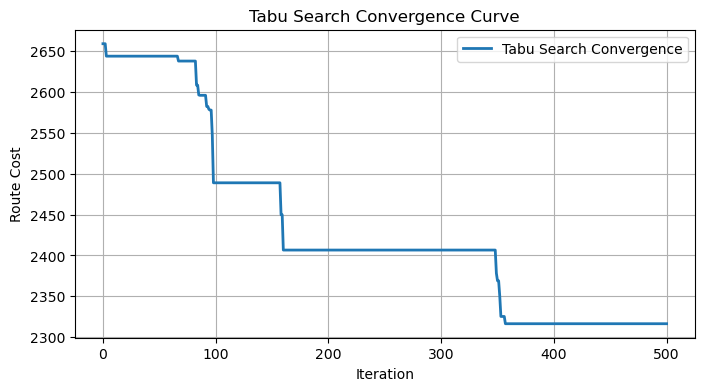

In [19]:

best_route, best_cost, tabu_history = tabu_search(dist_matrix)

plt.figure(figsize=(8, 4))
plt.plot(tabu_history, label="Tabu Search Convergence", linewidth=2)

plt.title("Tabu Search Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Route Cost")
plt.grid(True)
plt.legend()

logging.info("Tabu convergence plot generated.")
print(f"Final Tabu best cost: {best_cost}")
